# Imports, data loading and data cleaning

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from scipy.stats import spearmanr


# Import training data
train = pd.read_parquet("2022_to_2024_data.parquet")
train = train.dropna()

# Clean from irrelevant instances
train = train[train["ClassifiedPosition"] != "R"]   # R: Retired
train = train[train["ClassifiedPosition"] != "W"]   # W: Withdrawn
train = train[train["ClassifiedPosition"] != "D"]   # D: Disqualified

# Drop Abbreviations since there are new drivers for the 2025 season, drop season since 2025 does not exist in the training data
train = train.drop(columns = ["Abbreviation", "Season"])
# The fastF1 api assignes start from pit 0 change it to 21 because you are last if you start from pit

train["GridPosition"] = train["GridPosition"].replace(0, 21)


# Import test data, redo same preprocessing as for the training data
test = pd.read_parquet("2025_data.parquet")
test = test.dropna()

test = test[test["ClassifiedPosition"] != "R"]
test = test[test["ClassifiedPosition"] != "W"]
test = test[test["ClassifiedPosition"] != "D"]

# Drop Abbreviations since there are new drivers for the 2025 season, drop season since 2025 does not exist in the training data
test = test.drop(columns = ["Abbreviation", "Season"])

# The fastF1 api assignes start from pit 0 change it to 21 because you are last if you start from pit
test["GridPosition"] = test["GridPosition"].replace(0, 21)

# Preprocessing and splitting

In [36]:
# Splitting into X and y data
X_train = train.drop(columns= ["ClassifiedPosition"])
y_train = train["ClassifiedPosition"]

X_test = test.drop(columns = ["ClassifiedPosition"])
y_test = test["ClassifiedPosition"]

# Categorical encoding for categorical features
categorical_cols = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()  # Extract categorical cols
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()    # Extract numerical cols

encoder = OneHotEncoder(categories = "auto", handle_unknown = "ignore", sparse_output = False)
encoder.fit(X_train[categorical_cols])

X_train_cat = encoder.transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Normalizing numerical columns
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_num = scaler.transform(X_train[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

# Restack numeric cols together with now encoded columns
X_train = np.hstack([X_train_num, X_train_cat])
X_test = np.hstack([X_test_num, X_test_cat])


# Categorize y for classification
y_train = np.array(pd.to_numeric(y_train))   # First make y numeric, also convert to numpy
y_test = np.array(pd.to_numeric(y_test))

# Function we tried but decided to not use, grouping positions in 3 subgroups
def positional_mapping(y):
    y_mapped = []
    for n in range(len(y)):
        val = y[n]
        if 1 <= val <= 3:      # Podium (1-3) => 0
            y_mapped.append(0)
        elif 4 <= val <= 10:   # Top 10 (4-10) => 1
            y_mapped.append(1)
        else:
            y_mapped.append(2)  # Outside top 10 => 2
    return y_mapped


# Visualize data distribution with DR techniques

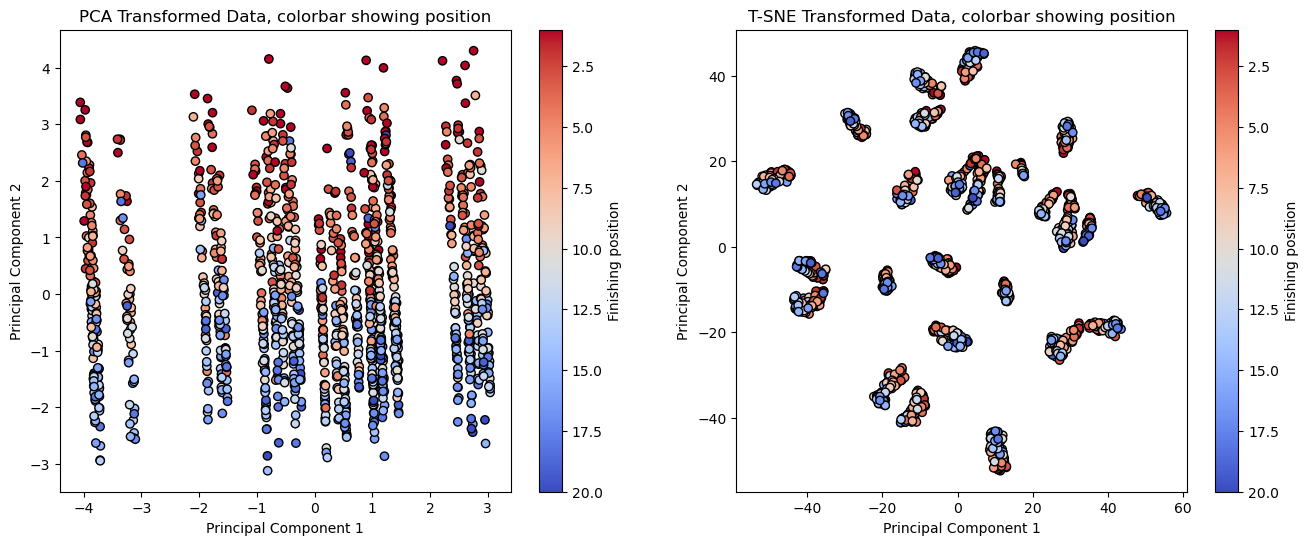

In [37]:
# Temporarily stack together train and test data for visualization of the whole dataset
all_X_data = np.vstack([X_train, X_test])
all_y_data = np.hstack([y_train, y_test])

# PCA, variance perserving DR technique
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(all_X_data)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_y_data, cmap='coolwarm_r', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Transformed Data, colorbar showing position")
plt.colorbar(label='Finishing position').ax.invert_yaxis()

# TSNE transformation, "cluster belonging"-preserving
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(all_X_data)

plt.subplot(1,2,2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_y_data, cmap='coolwarm_r', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("T-SNE Transformed Data, colorbar showing position")
plt.colorbar(label='Finishing position').ax.invert_yaxis()
plt.show()

# Function that makes our regression models into a classification

The function ranks the predicted positions and then converts the rank to the predicted position for each race. Classification model was tried first but this didn´t work well and drivers were predicted the same position. 

In [38]:
# Function for translating predictions of floats into discrete position predictions
def group_wise_reg(y_predict, res_test):
    # Make dataframe column out of predictions
    pred_df = pd.DataFrame(y_predict, columns=["Predictions"])

    # Align indices between test data copy DF and prediction DF
    res_test = res_test.reset_index(drop=True)
    pred_df = pred_df.reset_index(drop=True)

    # Add prediction column DF to the test_copy, rank predicted values based on size race-wise
    res_test["Predicted"] = pred_df["Predictions"].values
    res_test["PredictedPosition"] = res_test.groupby("Track_location")["Predicted"].rank(method="first")

    # Convert ranking to predicted position in race
    res_test["PredictedPosition"] = res_test["PredictedPosition"].astype(int)

    # Extract position predictions and true positions
    y_pred_pos = res_test["PredictedPosition"]
    y_true = res_test["ClassifiedPosition"]
    return y_pred_pos, y_true

# Linear regression model

In [11]:
# Train a Linear Regression model
model = LinearRegression()

model.fit(X_train, y_train)
y_lin_pred_vals = model.predict(X_test)

# Make copy of test dataframe to use in the function
res_test = test.copy()
y_pred_lin, y_true = group_wise_reg(y_lin_pred_vals, res_test)

r2_lin = r2_score(y_pred_lin, y_true)
print(f"R2 obtained from Linear Regression with race group rankings: {r2_lin}")

#Check winner predictiveability
y_pred_winner = np.where(y_pred_lin == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")

# Check podium predictiveability
y_pred_podium = np.where(y_pred_lin <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <= 3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")


R2 obtained from Linear Regression with race group rankings: 0.5254156769596199
Winner accuracy: 0.1
Podium accuracy: 0.6


# Elastic Net regression

In [12]:
# Train a Elastic Net Regression model

# Standard grid search for best parameters
model = ElasticNet(max_iter = 100000)
elastic_grid = {"alpha": [0.1, 0.05, 1, 10],
              "l1_ratio": [0, 0.2, 0.5, 0.7, 1.0]}

grid_search = GridSearchCV(estimator = model, param_grid = elastic_grid, scoring = "r2", cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

# Print best params from the grid search, get best model and get predictions from it
print(f"Best params: {grid_search.best_params_}")
best_est = grid_search.best_estimator_
y_elastic_pred_vals = best_est.predict(X_test)

res_test = test.copy()
y_pred_elastic, y_true = group_wise_reg(y_elastic_pred_vals, res_test)

# Compute R2 of best model from grid search
r2_elastic = r2_score(y_pred_elastic, y_true)
print(f"R2 obtained from Elastic Net using Grid search with race group ranking: {r2_elastic}")

# Check indices for winner to calculate winner accuracy
y_pred_winner = np.where(y_pred_elastic == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")

# Podium accuracy
y_pred_podium = np.where(y_pred_elastic <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <=3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.275e+03, tolerance: 2.555e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.204e+03, tolerance: 2.505e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Best params: {'alpha': 0.05, 'l1_ratio': 0}
R2 obtained from Elastic Net using Grid search with race group ranking: 0.585748218527316
Winner accuracy: 0.4
Podium accuracy: 0.6666666666666666


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.138e+03, tolerance: 3.158e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


# Random Forest Regressor

In [13]:
# Best params found by grid search: max_depth: 5, min_smaples_split: 5, n_estimators: 200

# Train the RandomForest regressor on the hyperparameters found from the gridsearch
model = RandomForestRegressor(max_depth= 5, min_samples_split= 5, n_estimators= 200)
model.fit(X_train, y_train)
y_pred_vals = model.predict(X_test)

# rank the predicted at each race and then convert rank into the predicted position
res_test = test.copy()
y_pred, y_true = group_wise_reg(y_pred_vals, res_test)

# evaluate model on R2-score
r2_rf = r2_score(y_pred, y_true)
print(f"R2 obtained from Random Forest using Grid search with race group ranking: {r2_rf}")

# Check winner accuracy
y_pred_winner = np.where(y_pred == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")

# Check podium accuracy
y_pred_podium = np.where(y_pred <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <=3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")

R2 obtained from Random Forest using Grid search with race group ranking: 0.6185273159144893
Winner accuracy: 0.6
Podium accuracy: 0.6666666666666666


# Gradient Boosting Regressor

In [14]:
# Custom Spearman scorer
def spearman_scorer(y_true, y_pred):
    corr, _ = spearmanr(y_true, y_pred)
    return 0.0 if np.isnan(corr) else corr

spearman_score = make_scorer(spearman_scorer, greater_is_better=True)


In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


gb_mse = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

gb_mse.fit(X_train, y_train)

gb_spearman = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring=spearman_score,
    cv=5,
    n_jobs=-1
)
gb_spearman.fit(X_train, y_train)

print("GradientBoosting (MSE):", gb_mse.best_params_, gb_mse.best_score_)
print("GradientBoosting (Spearman):", gb_spearman.best_params_, gb_spearman.best_score_)





/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GradientBoosting (MSE): {'learning_rate': 0.07, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.6} -10.514977544867794
GradientBoosting (Spearman): {'learning_rate': 0.03, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8} 0.787701322956097


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Spearman: 'learning_rate': 0.03, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
# MSE: learning_rate: 0.05, max_depth: 3, n_estimators: 100, subsample 0.8 
# MSE: learning_rate': 0.07, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.6

# Train the Gradient Boosting regressor on the hyperparameters found from the gridsearch
'''
lin = LinearRegression()
sfs = SequentialFeatureSelector(
    lin,
    n_features_to_select=3,  
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train, y_train)


# Combine numerical and encoded categorical names
all_feature_names = numerical_cols + list(encoder.get_feature_names_out(categorical_cols))

# Show selected feature names
selected_features = np.array(all_feature_names)[sfs.get_support()]
print("Selected features:")
print(selected_features)


X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)
'''

model = GradientBoostingRegressor(learning_rate=0.07, max_depth=3, n_estimators=50, subsample=0.6, min_samples_split=2, 
                                  min_samples_leaf=4)

model.fit(X_train, y_train)
y_pred_vals = model.predict(X_test)

# rank the predicted at each race and then convert rank into the predicted position
res_test = test.copy()
y_pred, y_true = group_wise_reg(y_pred_vals, res_test)

# evaluate the model using R2 score 
r2_GB = r2_score(y_pred, y_true)
print(f"R2 obtained from Gradient Boosting using Grid search with race group ranking: {r2_GB}")

# Check winner accuracy
y_pred_winner = np.where(y_pred == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")

# Check podium accuracy
y_pred_podium = np.where(y_pred <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <=3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")


# Best results from this model Winner accuracy: 0.8, Podium accuracy: 0.7

# Winner accuracy: 0.7, Podium accuracy: 0.7666666666666667


R2 obtained from Gradient Boosting using Grid search with race group ranking: 0.6205243760383448
Winner accuracy: 0.7272727272727273
Podium accuracy: 0.7272727272727273


# Store the predicted results

In [116]:
A = pd.DataFrame(y_pred_vals, columns=["Prediction"])

# Ensure matching index
res_test = res_test.reset_index(drop=True)
A = A.reset_index(drop=True)

# Add predictions
res_test["Predicted"] = A["Prediction"].values

res_test["PredictedPosition"] = res_test.groupby("Track_location")["Predicted"] \
                                        .rank(method="first")  

# Convert float to int (positions)
res_test["PredictedPosition"] = res_test["PredictedPosition"].astype(int)

res_test.to_parquet("predicted_results.parquet", index=False)

# Support Vector Machine

In [33]:
# Best params; C: 1, gamma: auto, kernel: rbf

# Train the SVM on the hyperparameters found from the gridsearch
model = SVR(C=1, gamma= 'auto', kernel='rbf')
model.fit(X_train, y_train)
y_pred_vals = model.predict(X_test)

# rank the predicted at each race and then convert rank into the predicted position
res_test = test.copy()
y_pred, y_true = group_wise_reg(y_pred_vals, res_test)

# Evaluate the model with R2-score
r2_rf = r2_score(y_pred, y_true)
print(f"R2 obtained from SVM using Grid search found parameters, with race group ranking: {r2_rf}")

# Check winner accuracy
y_pred_winner = np.where(y_pred == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")

# Check podium accuracy
y_pred_podium = np.where(y_pred <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <=3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")

R2 obtained from SVM using Grid search found parameters, with race group ranking: 0.6128266033254157
Winner accuracy: 0.5
Podium accuracy: 0.6666666666666666


# Neural Network

In [34]:
# Best params found using gridsearch; activation: 'relu', alpha: 0.0001, hidden_layer_sizes:(50)

# Train the Neural Network on the hyperparameters found from the gridsearch
model = MLPRegressor(hidden_layer_sizes=(50), activation='relu', alpha=0.0001)
model.fit(X_train, y_train)
y_pred_vals = model.predict(X_test)


# rank the predicted at each race and then convert rank into the predicted position
res_test = test.copy()
y_pred, y_true = group_wise_reg(y_pred_vals, res_test)

# Evaluate the model on R2-score
r2_rf = r2_score(y_pred, y_true)
print(f"R2 obtained from MLP using Grid search found parameters, with race group ranking: {r2_rf}")

# Check winner accuracy
y_pred_winner = np.where(y_pred == 1)[0]
y_true_winner = np.where(y_true == "1")[0]

print(f"Winner accuracy: {accuracy_score(y_pred_winner, y_true_winner)}")


# Check podium accuracy
y_pred_podium = np.where(y_pred <= 3)[0]
y_true_podium = np.where(y_true.astype(int) <=3)[0]

print(f"Podium accuracy: {accuracy_score(y_pred_podium, y_true_podium)}")

R2 obtained from MLP using Grid search found parameters, with race group ranking: 0.561520190023753
Winner accuracy: 0.2
Podium accuracy: 0.5333333333333333


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
